In [11]:
import openslide 
import os
import numpy as np
import cv2
import pandas as pd
import warnings
import histolab
from skimage.color import rgb2gray
from histolab.slide import Slide
from histolab.tiler import GridTiler
from histolab.masks import TissueMask
from skimage.measure import label, regionprops
from skimage.filters import threshold_local, threshold_otsu
import matplotlib.pyplot as plt
import mahotas as mh
from skimage.color import rgb2lab, rgb2luv
from scipy import stats
from glrlm import GLRLM
import warnings
from PIL import Image

In [3]:
BASE_PATH = os.getcwd()
PROCESS_PATH_ADENO = os.path.join(BASE_PATH, 'TEST2')
slide = Slide('TEST2/C3L-00004-21.svs', processed_path = PROCESS_PATH_ADENO)

In [4]:
print(f"Slide name: {slide.name}")
print(f"Levels: {slide.levels}")
print(f"Dimensions at level 0: {slide.dimensions}")
print(f"Dimensions at level 1: {slide.level_dimensions(level=1)}")
print(f"Dimensions at level 2: {slide.level_dimensions(level=2)}")

Slide name: C3L-00004-21
Levels: [0, 1, 2]
Dimensions at level 0: (25895, 23396)
Dimensions at level 1: (6473, 5849)
Dimensions at level 2: (3236, 2924)


In [6]:
print( "Native magnification factor:",slide.level_magnification_factor() )
print("Magnification factor corresponding to level 1:", slide.level_magnification_factor(level=1),)

Native magnification factor: 20.0X
Magnification factor corresponding to level 1: 5.0X


## Segmentation & Patching

#### We use TissueMask() to account all tissue detected on the slide
#### The tissue within the slide or tile is automatically detected through a predefined chain of filters

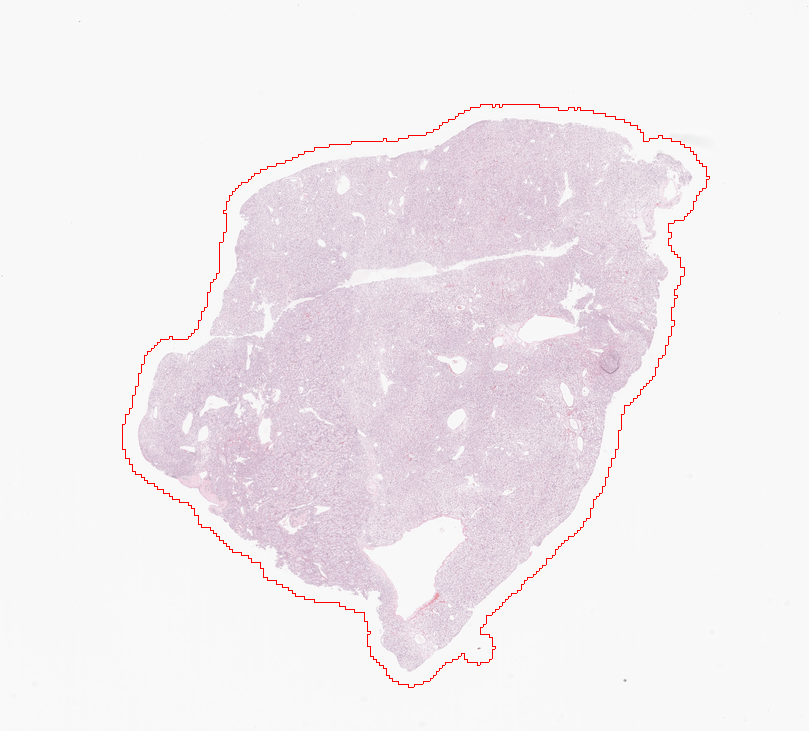

In [299]:
all_tissue_mask = TissueMask()
slide.locate_mask(all_tissue_mask)

#### We extract all patch of size (256 x 256) in the tissue region detected on the slide

In [301]:
grid_tiles_extractor = GridTiler(
   tile_size=(256, 256),
   level=0,
   check_tissue=True, 
   pixel_overlap=0, 
   prefix="grid/", # save tiles in the "grid" subdirectory of slide's processed_path
   suffix=".png" 
)

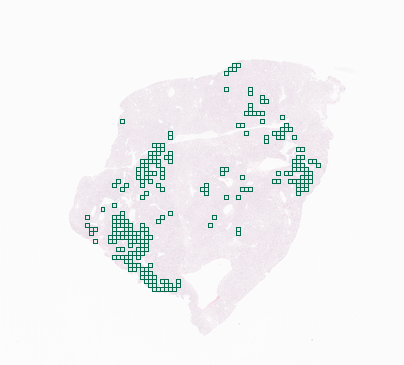

In [302]:
grid_tiles_extractor.locate_tiles(
    slide=slide,
    scale_factor=64,
    alpha=64,
    outline="#046C4C",
    extraction_mask=all_tissue_mask,
)

In [304]:
grid_tiles_extractor.extract(slide, all_tissue_mask)

# Feature Extraction

## Intensity Features
#### We extract intensity feature in seven distinct channel (Blue-ratio, Red, Blue, Green, L in LAB and V, L in LUV)
#### Mean, median, variance, maximum/minimum ratio, range, interquartile range, kurtosis and skewness of patch intensities at 7 color channels.
##### blue_ratio: This is the ratio of the blue component (blue channel) values of the image relative to the maximum value between the red and green channels. This can be used to measure the relative intensity of the blue component compared to the others.

##### patch[:, :, 0]: This extracts the first channel (red channel) of the image. Index 0 corresponds to the dimension of the red color in the channel axis.

##### patch[:, :, 1]: This extracts the second channel (green channel) of the image. Index 1 corresponds to the dimension of the green color in the channel axis.

##### patch[:, :, 2]: This extracts the third channel (blue channel) of the image. Index 2 corresponds to the dimension of the blue color in the channel axis.

##### lab_patch[:, :, 0]: This extracts the first channel (L channel) of the CIELAB color space of the image. Index 0 corresponds to the dimension of luminance (intensity) in the channel axis.

##### luv_patch[:, :, 2]: This extracts the third channel (V channel) of the CIELUV color space of the image. Index 2 corresponds to the dimension of the V component in the channel axis.

##### luv_patch[:, :, 0]: This extracts the first channel (L channel) of the CIELUV color space of the image. Index 0 corresponds to the dimension of luminance (intensity) in the channel axis.

#### We extract 8 * 7 = 56

In [100]:
def compute_intensity_feature (folder_path):
    png_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    warnings.filterwarnings("ignore")
    intensity_df = pd.DataFrame(columns=["image_name", "mean_channel1","median_channel1",	"variance_channel1",	"max_min_ratio_channel1",
                                         "peak_to_peak_channel1",	"iqr_channel1",	"kurtosis_channel1",	"skewness_channel1",
                                         "mean_channel2",	"median_channel2",	"variance_channel2",	"max_min_ratio_channel2",
                                         "peak_to_peak_channel2",	"iqr_channel2",	"kurtosis_channel2",	"skewness_channel2",
                                         "mean_channel3",	"median_channel3",	"variance_channel3",	"max_min_ratio_channel3",
                                         "peak_to_peak_channel3",	"iqr_channel3",	"kurtosis_channel3",	"skewness_channel3",
                                         "mean_channel4",	"median_channel4",	"variance_channel4",	"max_min_ratio_channel4",
                                         "peak_to_peak_channel4",	"iqr_channel4",	"kurtosis_channel4",	"skewness_channel4",
                                         "mean_channel5",	"median_channel5",	"variance_channel5",	"max_min_ratio_channel5",
                                         "peak_to_peak_channel5",	"iqr_channel5",	"kurtosis_channel5",	"skewness_channel5",
                                         "mean_channel6",	"median_channel6",	"variance_channel6",	"max_min_ratio_channel6",
                                         "peak_to_peak_channel6",	"iqr_channel6",	"kurtosis_channel6",	"skewness_channel6",
                                         "mean_channel7",	"median_channel7",	"variance_channel7",	"max_min_ratio_channel7",
                                         "peak_to_peak_channel7",	"iqr_channel7",	"kurtosis_channel7",	"skewness_channel7"])
    
    for file in png_files:
        image_path = os.path.join(folder_path, file)
        image_name = os.path.splitext(file)[0]
        with Image.open(image_path) as img:
            patch = img.convert('RGB')
            patch = np.array(patch)
            # Convert patch to LAB and LUV color spaces
            lab_patch = rgb2lab(patch)
            luv_patch = rgb2luv(patch)
            
            # Calculate blue ratio
            blue_ratio = patch[:, :, 2] / np.maximum(patch[:, :, 0], patch[:, :, 1])
            
            # Calculate intensity features
            channels = [blue_ratio, patch[:, :, 0], patch[:, :, 1], patch[:, :, 2], lab_patch[:, :, 0], luv_patch[:, :, 2], 
                        luv_patch[:, :, 0]]
            intensity_features = []
            for channel in channels:
                intensity_features.append(np.mean(channel))
                intensity_features.append(np.median(channel))
                intensity_features.append(np.var(channel))
                intensity_features.append(np.max(channel)/np.min(channel))
                intensity_features.append(np.ptp(channel))
                intensity_features.append(stats.iqr(channel))
                intensity_features.append(np.mean((channel - np.mean(channel)) ** 4) / np.mean((channel - np.mean(channel)) ** 2) ** 2 - 3)
                intensity_features.append(np.mean((channel - np.mean(channel)) ** 3) / np.mean((channel - np.mean(channel)) ** 2) ** (3/2))
            intensity_df = intensity_df.append(pd.Series([image_name] + intensity_features, index=intensity_df.columns), ignore_index=True)
    return intensity_df

In [307]:
intensity_feature = compute_intensity_feature('TEST2/grid')
intensity_feature

,image_name,mean_channel1,median_channel1,variance_channel1,max_min_ratio_channel1,peak_to_peak_channel1,iqr_channel1,kurtosis_channel1,skewness_channel1,mean_channel2,...,kurtosis_channel6,skewness_channel6,mean_channel7,median_channel7,variance_channel7,max_min_ratio_channel7,peak_to_peak_channel7,iqr_channel7,kurtosis_channel7,skewness_channel7
0,tile_11_level0_7242-13809-7498-14065,0.955897,0.944915,0.024627,15.249194,2.984124,0.116132,10.237384,1.098314,192.446503,...,0.462105,-0.145808,66.720117,68.739971,286.102447,19.222701,94.774274,20.190680,0.132266,-0.688440
1,tile_12_level0_7242-14065-7498-14321,0.917443,0.928571,0.038234,14.983516,2.907464,0.137347,5.454760,0.024463,191.436478,...,0.575766,0.081828,64.317164,66.335726,294.740258,20.514823,95.125476,23.087704,-0.251016,-0.477930
2,tile_5_level0_5962-15345-6218-15601,0.913457,0.896396,0.011212,6.545455,2.772727,0.063215,44.976810,5.256113,219.499390,...,3.912126,-1.272279,75.608240,77.343485,116.438852,12.766795,92.167180,8.144986,9.268123,-2.462571
3,tile_7_level0_6986-15089-7242-15345,0.975058,0.946746,0.031277,7.503676,2.816879,0.131469,11.401647,2.384004,190.479416,...,0.338176,-0.401951,66.320159,68.878088,351.373103,13.146344,92.370376,22.219444,0.022633,-0.692566
4,tile_9_level0_7242-11761-7498-12017,0.971305,0.957831,0.020523,14.070588,2.841432,0.100833,20.920000,2.472125,195.615524,...,0.492050,-0.291314,69.284267,70.894705,291.693335,15.860644,93.695086,20.667602,0.521434,-0.783243


## Morphological feature
#### The morphological features are extracted from binary mask
#### **area** : Number of pixels of the region.
#### **perimeter** : Perimeter of object which approximates the contour as a line through the centers of border pixels using a 4-connectivity.
#### **eccentricity** : Eccentricity of the ellipse that has the same second-moments as the region. The eccentricity is the ratio of the focal distance (distance between focal points) over the major axis length.
#### **equivalent_diameter_area** : float The diameter of a circle with the same area as the region.
#### **solidity** : Ratio of pixels in the region to pixels of the convex hull image.
#### **extent** : Ratio of pixels in the region to pixels in the total bounding box. Computed as ``area / (rows * cols)``
#### **axis_major_length** : The length of the major axis of the ellipse that has the same normalized second central moments as the region.
#### **axis_minor_length** : The length of the minor axis of the ellipse that has the same normalized second central moments as the region.
#### **orientation** : Angle between the 0th axis (rows) and the major axis of the ellipse that has the same second moments as the region ranging from -pi/2 to pi/2 counter-clockwise.
#### **area_convex** : int Number of pixels of convex hull image, which is the smallest convex polygon that encloses the region.
####  **feret_diameter_max** : float Maximum Feret's diameter computed as the longest distance between points around a region's convex hull contour as determined by find_contours
####  **euler_number** : Euler characteristic of the set of non-zero pixels. Computed as number of connected components subtracted by number of holes (input.ndim connectivity). In 3D, number of connected components plus number of holes subtracted by number of tunnels.
#### **area_bbox** : Number of pixels of bounding box.
#### **perimeter_crofton** : Perimeter of object approximated by the Crofton formula in 4 directions.
#### **area_filled** : Number of pixels of the region will all the holes filled in. Describes the area of the image_filled.

#### We extract 15 features

In [7]:
def compute_morphological_features (folder_path):
    png_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    warnings.filterwarnings("ignore")
     # Initialize a daraframe to store the morphological features
    morpho_feature = pd.DataFrame(columns=["image_name","area",	"perimeter",	"eccentricity",	"equivalent_diameter",	"solidity",	
                                             "extent",	"axis_major_length",	"axis_minor_length",	"orientation",	
                                             "convex_area",	"feret_diameter_max",	"euler_number",	"area_bbox",	
                                             "perimeter_crofton", "area_filled"])
    area = []; perimeter = []; eccentricity= []; equivalent_diameter = []; solidity = []; extent = []; axis_major_length = []; 
    axis_minor_length = []; orientation = []; convex_area = []; feret_diameter_max = []; euler_number = []; area_bbox = []; 
    perimeter_crofton = []; area_filled = []
    
    for file in png_files:
        image_path = os.path.join(folder_path, file)
        image_name = os.path.splitext(file)[0]
        with Image.open(image_path) as img:
            img = img.convert('RGB')
            patch = np.array(img) 
            patch = patch[:, :, :3]
            patch = rgb2gray(patch)
    # Threshold the image to create a binary mask
            threshold = threshold_otsu(patch)
            binary_mask = patch > threshold
            binary_mask = label(binary_mask)
    # Compute the region properties of the binary mask
            props = regionprops(binary_mask)
            feature = []
            for prop in props:
                area.append(prop.area)  # Area
                perimeter.append(prop.perimeter)  # Perimeter
                eccentricity.append(prop.eccentricity)  # Eccentricity
                equivalent_diameter.append(prop.equivalent_diameter)  # Equivalent diameter
                solidity.append(prop.solidity)  # Solidity
                extent.append(prop.extent)  # Extent
                axis_major_length.append(prop.axis_major_length)  # Major axis length
                axis_minor_length.append(prop.axis_minor_length)  # Minor axis length
                orientation.append(prop.orientation)  # Orientation
                convex_area.append(prop.convex_area)  # Convex area
                feret_diameter_max.append(prop.feret_diameter_max)  # feret_diameter_max
                euler_number.append(prop.euler_number)  # Euler number
                area_bbox.append(prop.area_bbox)  # area_bbox
                perimeter_crofton.append(prop.perimeter_crofton)  # perimeter_crofton
                area_filled.append(prop.area_filled)  # area_filled
            mean_values = [np.mean(area), np.mean(perimeter), np.mean(eccentricity), np.mean(equivalent_diameter), np.mean(solidity),
                           np.mean(extent), np.mean(axis_major_length), np.mean(axis_minor_length), np.mean(orientation), np.mean(convex_area),
                           np.mean(feret_diameter_max), np.mean(euler_number), np.mean(area_bbox), np.mean(perimeter_crofton), np.mean(area_filled)]
            morpho_feature = morpho_feature.append(pd.Series([image_name] + mean_values, index=morpho_feature.columns), ignore_index=True)
    return morpho_feature

In [14]:
morpho_feature= compute_morphological_features('TEST2/grid')
morpho_feature

,image_name,area,perimeter,eccentricity,equivalent_diameter,solidity,extent,axis_major_length,axis_minor_length,orientation,convex_area,feret_diameter_max,euler_number,area_bbox,perimeter_crofton,area_filled
0,tile_11_level0_7242-13809-7498-14065,958.875000,228.631671,0.539919,6.818095,0.959500,0.889111,8.141146,6.502844,0.386997,1369.041667,9.851866,-11.479167,1370.812500,217.252306,1155.979167
1,tile_12_level0_7242-14065-7498-14321,723.479675,178.364993,0.597396,7.110909,0.923196,0.815924,10.159551,6.352395,0.268104,1054.243902,11.415307,-8.398374,1146.894309,172.062216,909.089431
2,tile_5_level0_5962-15345-6218-15601,1201.880000,203.115469,0.596722,9.253159,0.922758,0.816345,12.404813,8.595844,0.266565,1561.720000,14.156305,-9.152000,1652.896000,194.016118,1414.704000
3,tile_7_level0_6986-15089-7242-15345,1114.560000,211.949480,0.568061,8.473614,0.934153,0.833862,11.154295,7.987699,0.363904,1491.028571,12.837584,-9.685714,1556.640000,202.733237,1356.594286
4,tile_9_level0_7242-11761-7498-12017,770.791531,161.555608,0.626322,6.930888,0.919802,0.803544,9.453031,6.291547,0.281276,1061.938111,10.649918,-6.905537,1116.302932,156.836595,940.309446


## Texture Feature
#### Texture feature are extracted from seven distinctive channels of patches (Blue-ratio, Red, Blue, Green, L in LAB and V, L in LUV)
#### Texture feature
                    "Angular Second Moment",
                   "Contrast",
                   "Correlation",
                   "Sum of Squares: Variance",
                   "Inverse Difference Moment",
                   "Sum Average",
                   "Sum Variance",
                   "Sum Entropy",
                   "Entropy",
                   "Difference Variance",
                   "Difference Entropy",
                   "Information Measure of Correlation 1",
                   "Information Measure of Correlation 2",
#### We extract 13 textures features of 7 channel ==> 13 * 7 = 91 features

#### All Features: 56 + 15 + 91 = 162

In [16]:
def texture_features (folder_path):
    png_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    warnings.filterwarnings("ignore")
    textfeature2 = []
    texture_feat2 = []
    tableau1 = []
    haralick_mean = pd.DataFrame()
    
     # Initialize dataframe to store the texture features
    mean_texture = pd.DataFrame(columns=["image_name","mean_ASM_chan1",	"mean_contrast_chan1",	"mean_correlation_chan1",	"mean_sum_of_squares_chan1",	"mean_IDM_chan1",	"mean_sum_average_chan1",	"mean_sum_variance_chan1",	"mean_sum_entropy_chan1",	"mean_Entropy_chan1",	"mean_difference_variance_chan1",	"mean_difference_entropy_chan1",	"mean_IMC1_chan1",	"mean_IMC2_chan1",
"mean_ASM_chan2",	"mean_contrast_chan2",	"mean_correlation_chan2",	"mean_sum_of_squares_chan2",	"mean_IDM_chan2",	"mean_sum_average_chan2",	"mean_sum_variance_chan2",	"mean_sum_entropy_chan2",	"mean_Entropy_chan2",	"mean_difference_variance_chan2",	"mean_difference_entropy_chan2",	"mean_IMC1_chan2",	"mean_IMC2_chan2",
"mean_ASM_chan3",	"mean_contrast_chan3",	"mean_correlation_chan3",	"mean_sum_of_squares_chan3",	"mean_IDM_chan3",	"mean_sum_average_chan3",	"mean_sum_variance_chan3",	"mean_sum_entropy_chan3",	"mean_Entropy_chan3",	"mean_difference_variance_chan3",	"mean_difference_entropy_chan3",	"mean_IMC1_chan3",	"mean_IMC2_chan3",
"mean_ASM_chan4",	"mean_contrast_chan4",	"mean_correlation_chan4",	"mean_sum_of_squares_chan4",	"mean_IDM_chan4",	"mean_sum_average_chan4",	"mean_sum_variance_chan4",	"mean_sum_entropy_chan4",	"mean_Entropy_chan4",	"mean_difference_variance_chan4",	"mean_difference_entropy_chan4",	"mean_IMC1_chan4",	"mean_IMC2_chan4",
"mean_ASM_chan5",	"mean_contrast_chan5",	"mean_correlation_chan5",	"mean_sum_of_squares_chan5",	"mean_IDM_chan5",	"mean_sum_average_chan5",	"mean_sum_variance_chan5",	"mean_sum_entropy_chan5",	"mean_Entropy_chan5",	"mean_difference_variance_chan5",	"mean_difference_entropy_chan5",	"mean_IMC1_chan5",	"mean_IMC2_chan5",
"mean_ASM_chan6",	"mean_contrast_chan6",	"mean_correlation_chan6",	"mean_sum_of_squares_chan6",	"mean_IDM_chan6",	"mean_sum_average_chan6",	"mean_sum_variance_chan6",	"mean_sum_entropy_chan6",	"mean_Entropy_chan6",	"mean_difference_variance_chan6",	"mean_difference_entropy_chan6",	"mean_IMC1_chan6",	"mean_IMC2_chan6",
"mean_ASM_chan7",	"mean_contrast_chan7",	"mean_correlation_chan7",	"mean_sum_of_squares_chan7",	"mean_IDM_chan7",	"mean_sum_average_chan7",	"mean_sum_variance_chan7",	"mean_sum_entropy_chan7",	"mean_Entropy_chan7",	"mean_difference_variance_chan7",	"mean_difference_entropy_chan7",	"mean_IMC1_chan7",	"mean_IMC2_chan7"])
   
    for file in png_files:
        image_path = os.path.join(folder_path, file)
        image_name = os.path.splitext(file)[0]
        with Image.open(image_path) as img:
            patch = np.array(img) 
            patch = patch[:, :, :3]
            # Convert patch to LAB and LUV color spaces
            lab_patch = rgb2lab(patch)
            luv_patch = rgb2luv(patch)
            
            # Calculate blue ratio
            blue_ratio = patch[:, :, 2] / np.maximum(patch[:, :, 0], patch[:, :, 1])
            
            # Calculate texture features
            channels = [blue_ratio, patch[:, :, 0], patch[:, :, 1], patch[:, :, 2], lab_patch[:, :, 0], luv_patch[:, :, 2], 
                        luv_patch[:, :, 0]]
            mean_text_feat = []
            for channel in channels:
                mean_text_feat.append(mh.features.haralick(channel.astype(np.uint8), return_mean=True))
            tableau = np.array(mean_text_feat).flatten().reshape(1, -1)
            df_patch = pd.DataFrame(tableau, columns=["mean_ASM_chan1",	"mean_contrast_chan1",	"mean_correlation_chan1",	"mean_sum_of_squares_chan1",	"mean_IDM_chan1",	"mean_sum_average_chan1",	"mean_sum_variance_chan1",	"mean_sum_entropy_chan1",	"mean_Entropy_chan1",	"mean_difference_variance_chan1",	"mean_difference_entropy_chan1",	"mean_IMC1_chan1",	"mean_IMC2_chan1",
"mean_ASM_chan2",	"mean_contrast_chan2",	"mean_correlation_chan2",	"mean_sum_of_squares_chan2",	"mean_IDM_chan2",	"mean_sum_average_chan2",	"mean_sum_variance_chan2",	"mean_sum_entropy_chan2",	"mean_Entropy_chan2",	"mean_difference_variance_chan2",	"mean_difference_entropy_chan2",	"mean_IMC1_chan2",	"mean_IMC2_chan2",
"mean_ASM_chan3",	"mean_contrast_chan3",	"mean_correlation_chan3",	"mean_sum_of_squares_chan3",	"mean_IDM_chan3",	"mean_sum_average_chan3",	"mean_sum_variance_chan3",	"mean_sum_entropy_chan3",	"mean_Entropy_chan3",	"mean_difference_variance_chan3",	"mean_difference_entropy_chan3",	"mean_IMC1_chan3",	"mean_IMC2_chan3",
"mean_ASM_chan4",	"mean_contrast_chan4",	"mean_correlation_chan4",	"mean_sum_of_squares_chan4",	"mean_IDM_chan4",	"mean_sum_average_chan4",	"mean_sum_variance_chan4",	"mean_sum_entropy_chan4",	"mean_Entropy_chan4",	"mean_difference_variance_chan4",	"mean_difference_entropy_chan4",	"mean_IMC1_chan4",	"mean_IMC2_chan4",
"mean_ASM_chan5",	"mean_contrast_chan5",	"mean_correlation_chan5",	"mean_sum_of_squares_chan5",	"mean_IDM_chan5",	"mean_sum_average_chan5",	"mean_sum_variance_chan5",	"mean_sum_entropy_chan5",	"mean_Entropy_chan5",	"mean_difference_variance_chan5",	"mean_difference_entropy_chan5",	"mean_IMC1_chan5",	"mean_IMC2_chan5",
"mean_ASM_chan6",	"mean_contrast_chan6",	"mean_correlation_chan6",	"mean_sum_of_squares_chan6",	"mean_IDM_chan6",	"mean_sum_average_chan6",	"mean_sum_variance_chan6",	"mean_sum_entropy_chan6",	"mean_Entropy_chan6",	"mean_difference_variance_chan6",	"mean_difference_entropy_chan6",	"mean_IMC1_chan6",	"mean_IMC2_chan6",
"mean_ASM_chan7",	"mean_contrast_chan7",	"mean_correlation_chan7",	"mean_sum_of_squares_chan7",	"mean_IDM_chan7",	"mean_sum_average_chan7",	"mean_sum_variance_chan7",	"mean_sum_entropy_chan7",	"mean_Entropy_chan7",	"mean_difference_variance_chan7",	"mean_difference_entropy_chan7",	"mean_IMC1_chan7",	"mean_IMC2_chan7"])
            df_patch.insert(0, 'image_name', image_name) 
            haralick_mean = haralick_mean.append(df_patch, ignore_index=True)
    return  haralick_mean

In [17]:
texture_feature = texture_features('TEST2/grid')
texture_feature

,image_name,mean_ASM_chan1,mean_contrast_chan1,mean_correlation_chan1,mean_sum_of_squares_chan1,mean_IDM_chan1,mean_sum_average_chan1,mean_sum_variance_chan1,mean_sum_entropy_chan1,mean_Entropy_chan1,...,mean_sum_of_squares_chan7,mean_IDM_chan7,mean_sum_average_chan7,mean_sum_variance_chan7,mean_sum_entropy_chan7,mean_Entropy_chan7,mean_difference_variance_chan7,mean_difference_entropy_chan7,mean_IMC1_chan7,mean_IMC2_chan7
0,tile_11_level0_7242-13809-7498-14065,0.437411,0.211841,0.471423,0.200390,0.894176,0.547205,0.589720,1.340012,1.552452,...,286.214440,0.189265,132.433620,1082.366999,6.956333,10.813743,0.000721,3.992807,-0.200154,0.950256
1,tile_12_level0_7242-14065-7498-14321,0.481443,0.188233,0.494075,0.186037,0.905985,0.486159,0.555915,1.264011,1.452795,...,294.635004,0.182547,127.635852,1111.361270,7.026139,10.953571,0.000677,4.053102,-0.197434,0.950066
2,tile_5_level0_5962-15345-6218-15601,0.808971,0.052731,0.641733,0.073603,0.973685,0.155907,0.241682,0.589964,0.642920,...,116.337491,0.276280,150.204737,437.223463,5.879597,9.039810,0.001131,3.398455,-0.183469,0.910114
3,tile_7_level0_6986-15089-7242-15345,0.414473,0.206051,0.526695,0.217677,0.897251,0.614075,0.664656,1.407454,1.614902,...,351.369111,0.189011,131.629733,1326.348474,7.043176,10.990385,0.000638,4.155697,-0.198524,0.951329
4,tile_9_level0_7242-11761-7498-12017,0.406082,0.237402,0.437742,0.211124,0.881419,0.589022,0.607093,1.399120,1.637227,...,291.278552,0.195744,137.623231,1104.063577,6.947539,10.759100,0.000731,3.971232,-0.205978,0.953542
